In [42]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Overview
Use this notebook to convert an OCT image you have to an H&E image in order to evaluate how the code works.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/zero_shot_segmentation/blob/main/zero_shot_segmentation_oct.ipynb)
 and run.


# inputs

In [43]:
# Path to an OCT image to convert
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Danny - Zero Shot Learning on OCT/input.jpg"


In [44]:
visualize_oct2hist_outputs = False

In [45]:
#rf
rf_api_key="R04BinsZcBZ6PsfKR2fP"
rf_workspace="yolab-kmmfx"
rf_project = "connect_from_colab"
rf_dataset = "png-mask-semantic"
#sam
using_colab = True
visualize_sam_outputs = False

In [46]:
#sam
model=sam
points_per_side=32
pred_iou_thresh=0.90
stability_score_thresh=0.95
crop_n_layers=1
crop_n_points_downscale_factor=2
min_mask_region_area=3000

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

#assumptions on input and oct2hist:

In [47]:
# oct scan x/z rates
microns_per_pixel_z = 1
microns_per_pixel_x = 1

# #pix2pix input sizes
VIRTUAL_HIST_WIDTH = 256
VIRTUAL_HIST_HEIGHT = 256

# #pix2pix input x/z rates
MICRONS_PER_PIXEL_Z_TARGET = 1
MICRONS_PER_PIXEL_X_TARGET = 2

oct scan x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 1

pix2pix input sizes:
*   virtual histology input width = 256
*   virtual histology input height = 256

pix2pix input x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 2

#get images

In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [49]:
#need to import this early on, so that libs that will be installed below match colab torch versions

import torch
import torchvision

In [50]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


install dependencies required to read the image

In [51]:
import os

# Clone repository
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel

base_folder = "/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix"

# Install dependencies
!pip install -r {base_folder}/requirements.txt

# Clean up this window once install is complete
from IPython.display import clear_output
clear_output()

In [52]:
#TODO: DELETE THIS WHEN FOUND A GOOD IMAGE
oct_image = cv2.imread(oct_input_image_path)
oct_image = cv2.resize(oct_image,[512,256],cv2.INTER_AREA)

read it and verify it fits the input requirements.

In [53]:
#update the image to be 2mic/pix on the x axis, and 1mic/pix on the y axis.
new_image_width = int(oct_image.shape[1] * microns_per_pixel_x / MICRONS_PER_PIXEL_X_TARGET)
new_image_height = int(oct_image.shape[0] * microns_per_pixel_z / MICRONS_PER_PIXEL_Z_TARGET)

if new_image_width<VIRTUAL_HIST_WIDTH or VIRTUAL_HIST_HEIGHT<256:
  print(f"Image at target x/z rate is smaller than ({VIRTUAL_HIST_HEIGHT},{VIRTUAL_HIST_WIDTH}), and will be placed at top left corner.")
#warn about cropping
if new_image_width>VIRTUAL_HIST_WIDTH or new_image_height>VIRTUAL_HIST_HEIGHT:
  raise Exception(f"Image at target x/z rate is too large: ({new_image_height},{new_image_width}), please adjust so that it won't be larger than ({VIRTUAL_HIST_HEIGHT},{VIRTUAL_HIST_WIDTH}).")

In [54]:
#mask image
%cd /content/OCT2Hist-UseModel
from utils.masking_utils import mask_image
preprocessed_img = mask_image(oct_image)

/content/OCT2Hist-UseModel


In [55]:
#stick image to top left of a new oct2hist input
target_rate_img = cv2.resize(preprocessed_img, (new_image_width, new_image_height), interpolation=cv2.INTER_AREA)
o2h_input = np.zeros((VIRTUAL_HIST_HEIGHT,VIRTUAL_HIST_WIDTH, 3),dtype=np.uint8)
o2h_input[:new_image_height, :new_image_width,:] = target_rate_img

#run oct2hist

In [56]:
# Create a folder and place OCT image
!mkdir {base_folder}/dataset
!mkdir {base_folder}/dataset/test/

# Before writting image to file, check size
if o2h_input.shape[:2] != (256, 256):
        raise ValueError("Image size must be 256x256 pixels to run model on.")

# Padd image and write it to the correct place
padded = np.zeros([256,512,3], np.uint8)
padded[:,:256,:] = o2h_input[:,:,:]
cv2.imwrite(f"{base_folder}/dataset/test/im1.jpg", padded)

mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/dataset’: File exists
mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/dataset/test/’: File exists


True

In [57]:
# This is the folder that the pre-trained model is in
model_folder = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Model (Paper V2)"

# Copy model to this folder over
!mkdir {base_folder}/checkpoints
!mkdir {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_G.pth" {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_D.pth" {base_folder}/checkpoints/pix2pix/

mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints’: File exists
mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints/pix2pix/’: File exists


In [58]:
!python {base_folder}/test.py --netG resnet_9blocks --dataroot "{base_folder}/dataset/"  --model pix2pix --name pix2pix --checkpoints_dir "{base_folder}/checkpoints" --results_dir "{base_folder}/results"

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/dataset/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False  

#Optional: visualize output

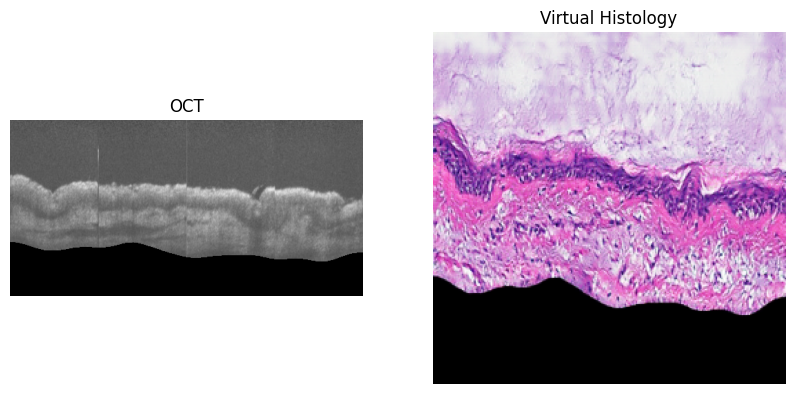

In [59]:
if visualize_oct2hist_outputs:
  # Load the virtual histology image
  histology_image = cv2.imread(f"{base_folder}/results/pix2pix/test_latest/images/im1_fake_B.png")
  histology_image = cv2.cvtColor(histology_image, cv2.COLOR_BGR2RGB)

  # present side by side
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(oct_image)
  axes[0].axis("off")
  axes[0].set_title("OCT")
  axes[1].imshow(histology_image)
  axes[1].axis("off")
  axes[1].set_title("Virtual Histology")
  plt.show()


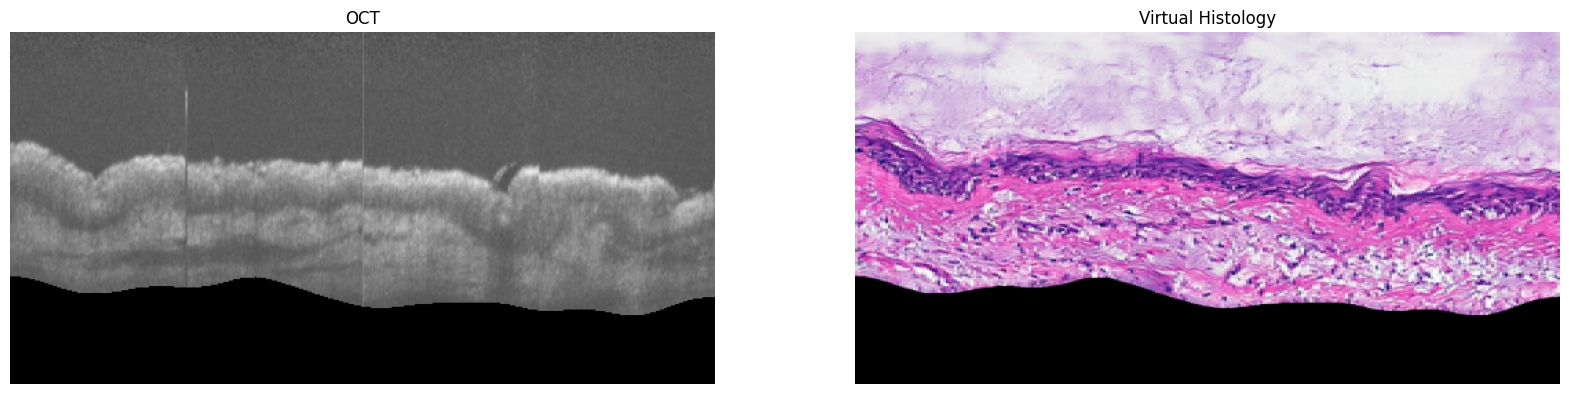

In [60]:
if visualize_oct2hist_outputs:
  height,width = preprocessed_img.shape[:2]
  histology_image_resized = cv2.resize(histology_image, [width,height] , interpolation=cv2.INTER_AREA)#visualize
  # present side by side
  fig, axes = plt.subplots(1, 2, figsize=(20, 10))
  axes[0].imshow(preprocessed_img)
  axes[0].axis("off")
  axes[0].set_title("OCT")
  axes[1].imshow(histology_image_resized)
  axes[1].axis("off")
  axes[1].set_title("Virtual Histology")
  plt.show()

#run sam on virtual histology

In [61]:
#util functions were taken from https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb#scrollTo=dZSU9BpHr2gc
!pip install dataclasses-json
!pip install supervision

import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [62]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=rf_api_key)
project = rf.workspace(rf_workspace).project(rf_project)
dataset = project.version(1).download(rf_dataset)

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to connect_from_colab-1 in png-mask-semantic:: 100%|██████████| 6/6 [00:00<00:00, 1187.24it/s]


In [63]:
import os
DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)
print(IMAGES_DIRECTORY_PATH)
print(ANNOTATIONS_FILE_PATH)

/content/OCT2Hist-UseModel/connect_from_colab-1/test
/content/OCT2Hist-UseModel/connect_from_colab-1/test/_annotations.coco.json


In [64]:
if using_colab:
  print("PyTorch version:", torch.__version__)
  print("Torchvision version:", torchvision.__version__)
  print("CUDA is available:", torch.cuda.is_available())
  import sys
  !{sys.executable} -m pip install opencv-python matplotlib
  !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  !mkdir images
  !wget -P images https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg&name=large
#https://twitter.com/JMGardnerMD/status/1655724394805706752/photo/1
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ruepei91
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ruepei91
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2023-08-02 03:40:27--  https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 72.21.91.70, 2a04:4e42:5::159
Connecting to pbs.twimg.com (pbs.twimg.com)|72.21.91.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254202 (248K) [image/jpeg]
Saving to: ‘images/FvpQj7UWYAAgxfo?format=jpg.1’

FvpQj7UWYAAgxfo?for 100%[===================>] 248.24K  --.-KB/s    in 0.02s   

2023-08-02 03:40:27 (

In [65]:
import supervision as sv

## Set-up

In [66]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [67]:
def show_anns(anns):

  if len(anns) == 0:
    return
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  ax = plt.gca()
  ax.set_autoscale_on(False)

  img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
  img[:,:,3] = 0
  for ann in sorted_anns:
      m = ann['segmentation']
      color_mask = np.concatenate([np.random.random(3), [0.35]])
      img[m] = color_mask
  ax.imshow(img)

## Example image

In [68]:
%matplotlib notebook
%matplotlib inline

In [69]:
type(dataset)

roboflow.core.dataset.Dataset

In [82]:
image = histology_image_resized

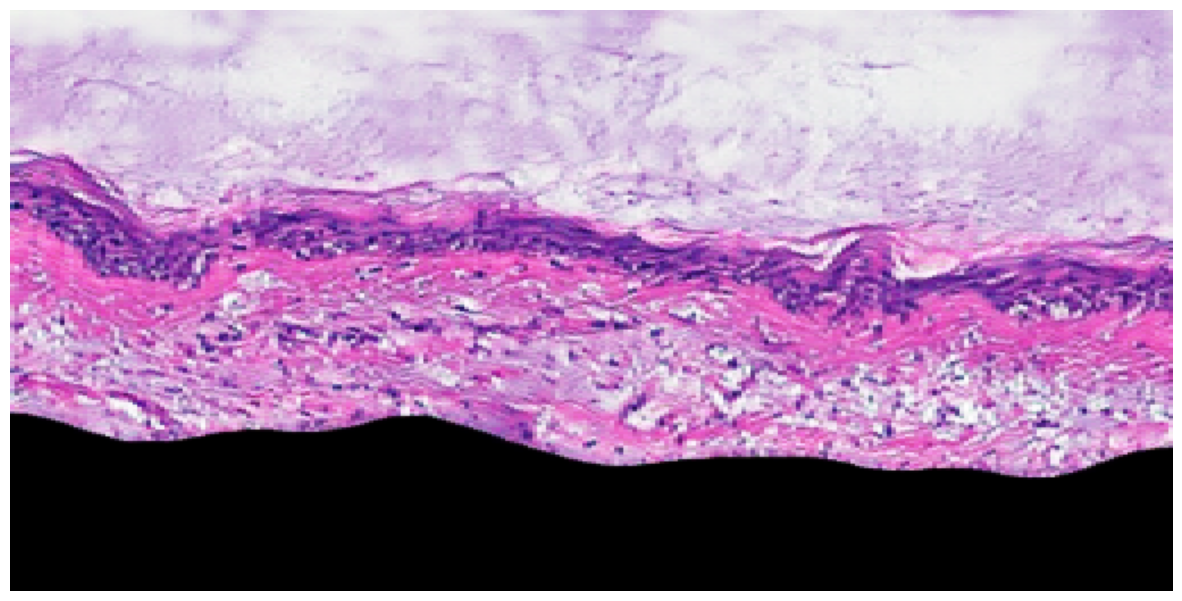

In [93]:
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.axis('off')
plt.show()


## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [84]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [85]:
masks = mask_generator.generate(image)

In [86]:
print(image.shape)

(256, 512, 3)


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [87]:
print(len(masks))
print(masks[0].keys())
print(masks[0])
print(masks[0]['segmentation'].shape)

27
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
{'segmentation': array([[False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 43881, 'bbox': [0, 1, 511, 98], 'predicted_iou': 1.0306254625320435, 'point_coords': [[344.0, 84.0]], 'stability_score': 0.9635214805603027, 'crop_box': [0, 0, 512, 256]}
(256, 512)


Show all the masks overlayed on the image.

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:[link text](https://)


In [88]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=points_per_side,
    pred_iou_thresh=pred_iou_thresh,
    stability_score_thresh=stability_score_thresh,
    crop_n_layers=crop_n_layers,
    crop_n_points_downscale_factor=crop_n_points_downscale_factor,
    min_mask_region_area=min_mask_region_area,
)

In [89]:
masks2 = mask_generator_2.generate(image)

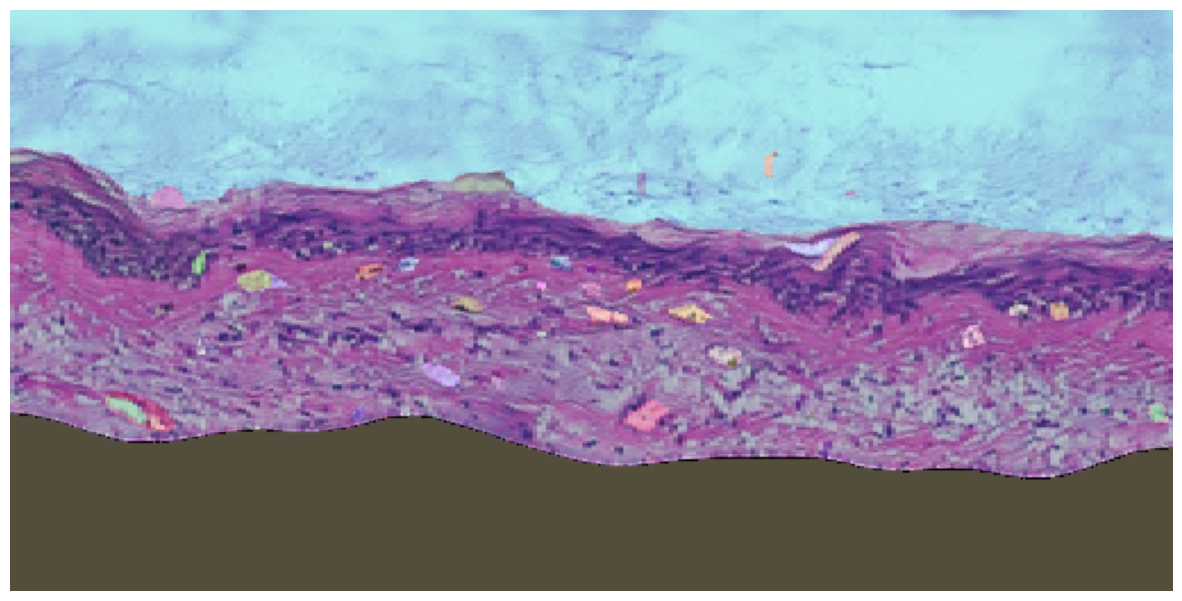

In [90]:
if visualize_sam_outputs:
  plt.figure(figsize=(15,15))
  plt.imshow(image)
  show_anns(masks2)
  plt.axis('off')
  plt.show()

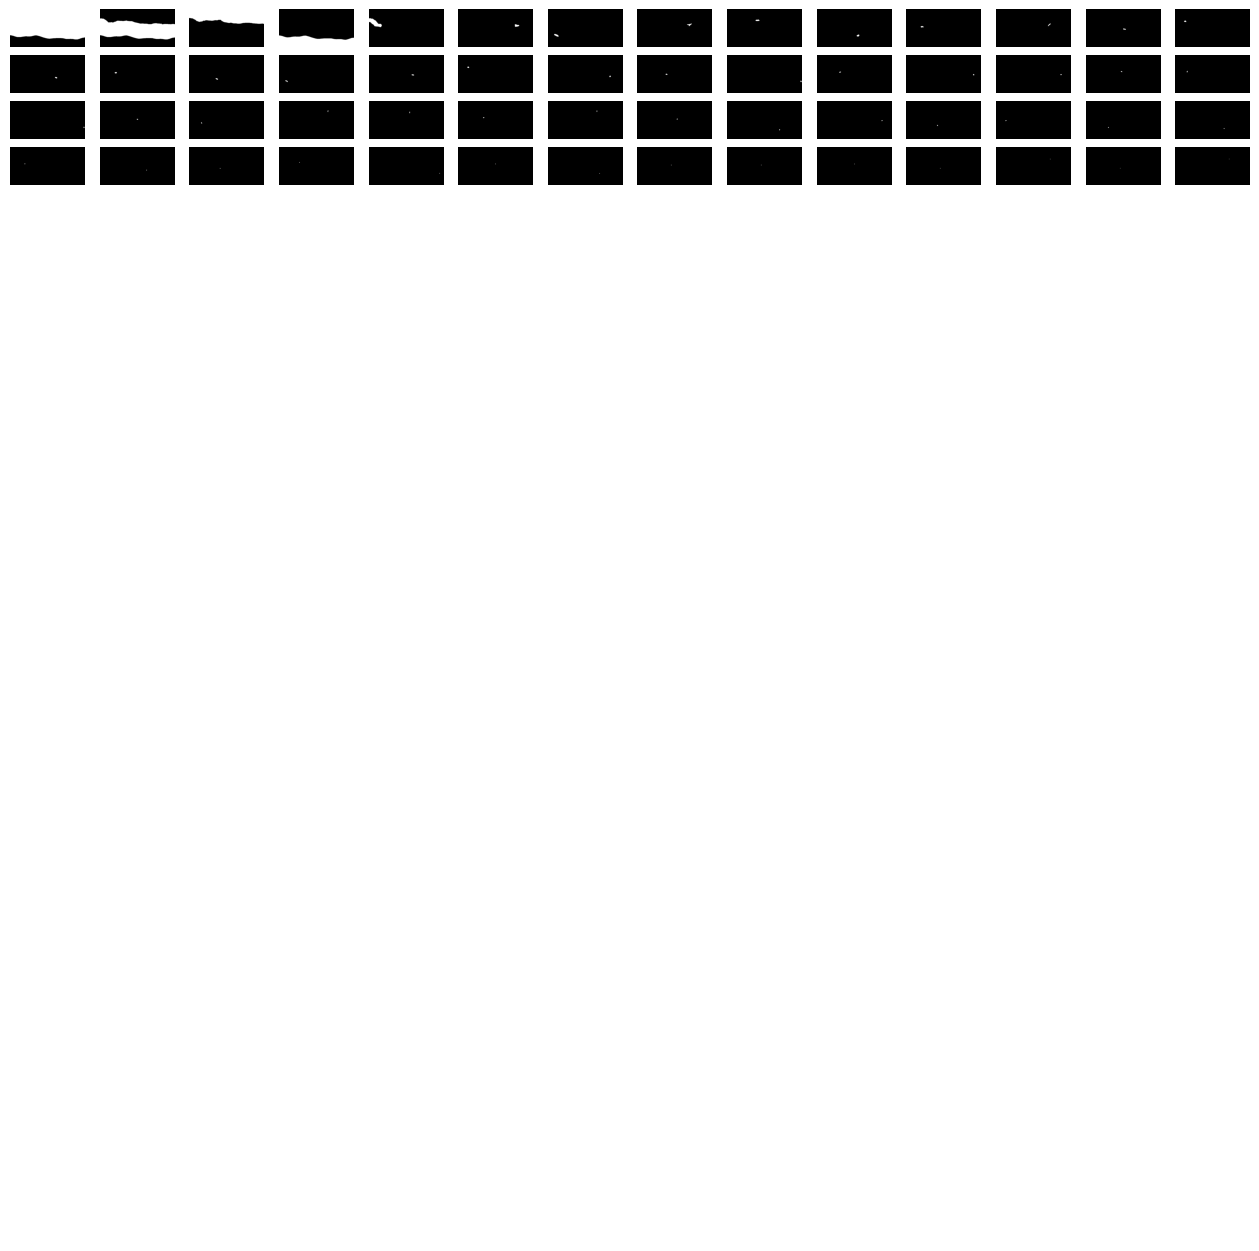

In [91]:
if visualize_sam_outputs:
  boolean_masks = [
      masks2['segmentation']
      for masks2
      in sorted(masks2, key=lambda x: x['area'], reverse=True)
  ]

  sv.plot_images_grid(
      images=boolean_masks,
      grid_size=(len(masks), int(len(boolean_masks) / 4)),
      size=(16, 16)
  )

#project on oct

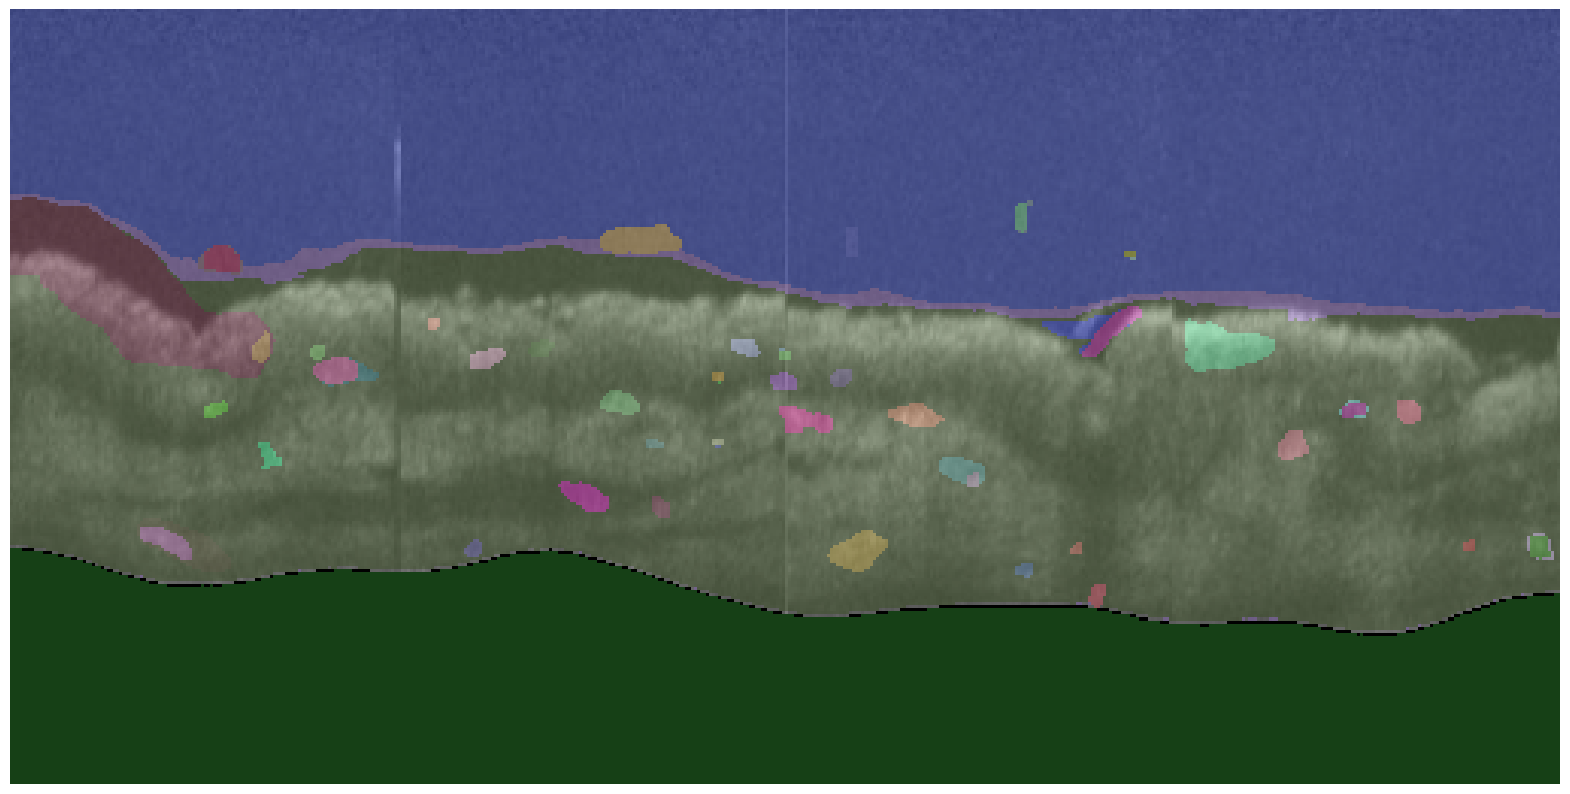

In [92]:
plt.figure(figsize=(20,20))
plt.imshow(oct_image)
show_anns(masks2)
plt.axis('off')
plt.show()